In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import random
import argparse
import tensorflow.keras as keras
from tensorflow.keras import layers, losses, optimizers
import sys
sys.path.append('../')
from birdsong_recognition.preprocess import *

In [3]:
from IPython.display import Audio

In [4]:
%cd ../

/Users/yingying/Documents/project/birdsong_recognition_v2


In [5]:
ebirds = ['norcar', 'blujay', 'bkcchi']

In [6]:
rerun_preprocessing = False
if rerun_preprocessing:
    preprocess(running_in_colab=False, ebirds=ebirds)

In [7]:
element_spec = (tf.TensorSpec(shape=(132300,), dtype=tf.float32, name='input'),
                tf.TensorSpec(shape=(), dtype=tf.int32, name='label'))

In [8]:
train_ds, val_ds, test_ds = create_ds(element_spec)

In [11]:
model = keras.models.load_model('model/model.h5')

In [57]:
def evaluate(model, ds):
    ds_ = ds.batch(1)
    history = model.evaluate(ds_)
    pred_logits = model.predict(ds_)
    pred = np.argmax(pred_logits, axis=1)
    
    layer = tf.keras.layers.Softmax()
    pred_prob = layer(pred_logits).numpy()
    
    ds_numpy = list(ds_.as_numpy_iterator())
    label = np.array([])
    for batch in ds_numpy:
        label = np.concatenate((label, batch[1]))
    
    assert label.shape[0] == pred.shape[0]
    assert pred.shape[0] == len(ds_numpy)
    
    errors = pred - label
    accuracy = 1-errors[errors != 0].shape[0]/len(ds_numpy)
    assert np.around(accuracy, decimals=2) == np.around(history[1], decimals=2)
    
    error_indices = np.where(errors != 0)[0]
    return pred, label, pred_prob, error_indices

In [58]:
test_pred, test_label, test_pred_prob, test_error_indices = evaluate(model, test_ds)

151/151 [==============================] - 4s 23ms/step - loss: 0.5818 - accuracy: 0.8609


In [15]:
audio_test_ds_ = tf.data.experimental.load('preprocessed_dataset/test_ds', element_spec=element_spec)
audio_test_ds = list(audio_test_ds_)

### Often times, the clip with error just has noise. This is because the clips are made by splitting up longer audio pieces into 3 seconds pieces. There could be long gaps in the song.

In [59]:
pred = test_pred
label = test_label
error_indices = test_error_indices 
pred_prob = test_pred_prob
audio_ds = audio_test_ds

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [60]:
label = label.astype(int)

In [61]:
cfm = confusion_matrix(label, pred, labels=list(range(0,3)))

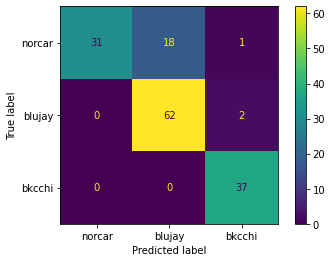

In [62]:
cfm_display = ConfusionMatrixDisplay(cfm, display_labels=ebirds)
cfm_display.plot()

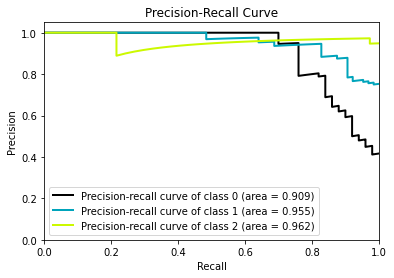

In [65]:
import matplotlib.pyplot as plt
import scikitplot as skplt

# Now plot.
skplt.metrics.plot_precision_recall(label, pred_prob, plot_micro=False)
plt.show()

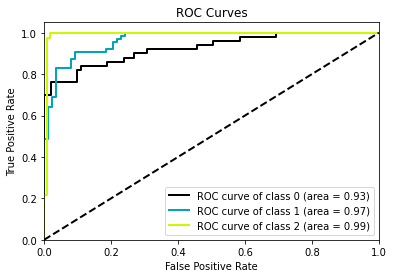

In [63]:
skplt.metrics.plot_roc(label, pred_prob, plot_macro=False, plot_micro=False)
plt.show()

In [71]:
error_index = np.random.choice(error_indices)
error_pred = ebirds[pred[error_index]]
error_label = ebirds[label[error_index]]
print('predicted label: {}, actual label: {}'.format(error_pred, error_label))
print('classes: {}'.format(ebirds))
print('logits: {}'.format(pred_prob[error_index]))
Audio(audio_ds[error_index][0], rate=44.1e3)

predicted label: blujay, actual label: norcar
classes: ['norcar', 'blujay', 'bkcchi']
logits: [1.1192566e-08 9.9999785e-01 2.1088924e-06]


In [ ]:
## sample index = 22. A guy talking?
## sample index = 115. Just noise?
## sample index = 61. sometimes the model is very confident

In [ ]:
## look at the cases where the model is less confident to see what could be happening

In [96]:
correct_indices = [i for i in range(len(pred)) if i not in set(error_indices)]
correct_index = np.random.choice(correct_indices)
correct_pred = ebirds[pred[correct_index]]
print('sampled index: {}'.format(correct_index))
print('predicted label: {}'.format(correct_pred))
print('classes: {}'.format(ebirds))
print('logits: {}'.format(pred_prob[correct_index]))
Audio(audio_ds[correct_index][0], rate=44.1e3)

sampled index: 3
predicted label: norcar
classes: ['norcar', 'blujay', 'bkcchi']
logits: [0.8209365  0.1779526  0.00111092]


In [50]:
bird_index, bird_index_count = np.unique(label, return_counts=True)
for i, bird in enumerate(bird_index):
    print('bird: {} has {} 3-sec samples.'.format(ebirds[bird], bird_index_count[i]))

bird: norcar has 50 3-sec samples.
bird: blujay has 64 3-sec samples.
bird: bkcchi has 37 3-sec samples.


In [51]:
error_by_bird_index = label[error_indices]
error_bird_index, error_bird_index_count = np.unique(error_by_bird_index, return_counts=True)

error_bird_index_array = np.zeros(len(bird_index))
for i, error_index in enumerate(error_bird_index):
    error_bird_index_array[int(error_index)] = error_bird_index_count[i]
    
percent_error = np.around(100*error_bird_index_array/bird_index_count, decimals=2)
for i, bird in enumerate(bird_index):
    print('bird: {} has {} error samples, or {} percent error.'.format(ebirds[bird], 
                                                                       error_bird_index_array[i], percent_error[i]))

bird: norcar has 19.0 error samples, or 38.0 percent error.
bird: blujay has 2.0 error samples, or 3.12 percent error.
bird: bkcchi has 0.0 error samples, or 0.0 percent error.


### Looking at errors from log.

In [6]:
with open('error_log', 'r') as f:
    errors = f.readlines()

In [65]:
i = -11
bird = errors[i].split('/')[-2]
bird

'norcar'

In [66]:
# parse out file name from log file
Audio(errors[i].split(':')[-1].strip())

In [38]:
audio_dir = 'dataset/'+bird
sample = np.random.choice(os.listdir(audio_dir))
Audio(os.path.join(audio_dir, sample))

In [60]:
audio_dir+'/'+sample, errors[i]

('dataset/blujay/XC165323.mp3', 'ERROR:root:./dataset/norcar/XC321934.mp3\n')